In [116]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import jaccard_score
from skimage.filters import threshold_sauvola


In [117]:
IMAGE_DIR = "/kaggle/input/brain-tumor-segmentation/images"
MASK_DIR  = "/kaggle/input/brain-tumor-segmentation/masks"

image_files = sorted(os.listdir(IMAGE_DIR))
mask_files  = sorted(os.listdir(MASK_DIR))

print("Total Images:", len(image_files))

Total Images: 3064


In [118]:
def dice_score(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-8)


In [119]:
def jaccard(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    intersection = np.sum(y_true * y_pred)
    union = np.sum((y_true + y_pred) > 0)
    
    return intersection / (union + 1e-8)

In [120]:
def clean_mask(binary_mask):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    cleaned = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel)
    return cleaned

In [121]:
def otsu_segmentation(img):
    blur = cv2.GaussianBlur(img, (5,5), 0)
    _, mask = cv2.threshold(blur, 0, 255,
                            cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return mask

In [122]:
def sauvola_segmentation(img):
    window_size = 51
    thresh = threshold_sauvola(img, window_size=window_size)
    binary = (img > thresh).astype(np.uint8) * 255
    return binary

In [123]:
def preprocess(img):
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    
    # CLAHE (Adaptive contrast enhancement)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    
    img = cv2.GaussianBlur(img, (5,5), 0)
    
    return img

In [124]:
def compute_metrics(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    
    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)  # Sensitivity
    specificity = TN / (TN + FP + 1e-8)
    accuracy = (TP + TN) / (TP + TN + FP + FN + 1e-8)
    
    return precision, recall, specificity, accuracy


In [125]:
dice_otsu = []
dice_sauvola = []

jaccard_otsu = []
jaccard_sauvola = []

precision_otsu, recall_otsu, spec_otsu, acc_otsu = [], [], [], []
precision_sauvola, recall_sauvola, spec_sauvola, acc_sauvola = [], [], [], []


for img_file, mask_file in tqdm(zip(image_files, mask_files), total=len(image_files)):
    
    # Load image and mask
    img = cv2.imread(os.path.join(IMAGE_DIR, img_file), cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(os.path.join(MASK_DIR, mask_file), cv2.IMREAD_GRAYSCALE)
    
    # Resize (optional but ensures consistency)
    img = cv2.resize(img, (256,256))
    mask = cv2.resize(mask, (256,256))
    
    # Binarize mask
    mask = (mask > 127).astype(np.uint8)
    
    # preprocessing
    # img = preprocess(img) // getting worse results so removed
    
    # Otsu 
    otsu_mask = otsu_segmentation(img)
    otsu_mask = clean_mask(otsu_mask)
    if np.sum(otsu_mask) > 0:
        otsu_mask = keep_largest_component(otsu_mask)
    otsu_mask = otsu_mask.astype(np.uint8)
    
    # Sauvola
    sauvola_mask = sauvola_segmentation(img)
    sauvola_mask = clean_mask(sauvola_mask)
    if np.sum(sauvola_mask) > 0:
        sauvola_mask = keep_largest_component(sauvola_mask)
    sauvola_mask = sauvola_mask.astype(np.uint8)
    
    # Metrics
    dice_otsu.append(dice_score(mask, otsu_mask))
    dice_sauvola.append(dice_score(mask, sauvola_mask))
    
    jaccard_otsu.append(jaccard(mask, otsu_mask))
    jaccard_sauvola.append(jaccard(mask, sauvola_mask))

    p, r, s, a = compute_metrics(mask, otsu_mask)
    precision_otsu.append(p)
    recall_otsu.append(r)
    spec_otsu.append(s)
    acc_otsu.append(a)
    
    p, r, s, a = compute_metrics(mask, sauvola_mask)
    precision_sauvola.append(p)
    recall_sauvola.append(r)
    spec_sauvola.append(s)
    acc_sauvola.append(a)


100%|██████████| 3064/3064 [00:42<00:00, 71.34it/s]


In [131]:
print("FINAL METRICS")

print("\n OTSU")
print("Dice:", np.mean(dice_otsu))
print("Jaccard:", np.mean(jaccard_otsu))
print("Precision:", np.mean(precision_otsu))
print("Recall:", np.mean(recall_otsu))
print("Specificity:", np.mean(spec_otsu))
print("Accuracy:", np.mean(acc_otsu))

print("\n SAUVOLA")
print("Dice:", np.mean(dice_sauvola))
print("Jaccard:", np.mean(jaccard_sauvola))
print("Precision:", np.mean(precision_sauvola))
print("Recall:", np.mean(recall_sauvola))
print("Specificity:", np.mean(spec_sauvola))
print("Accuracy:", np.mean(acc_sauvola))


FINAL METRICS

 OTSU
Dice: 0.07030045189400012
Jaccard: 0.03739211358016384
Precision: 0.03750596026188562
Recall: 0.9486978275736436
Specificity: 0.5484242595864645
Accuracy: 0.554899136017797

 SAUVOLA
Dice: 0.06247108341390775
Jaccard: 0.033172180196351764
Precision: 0.03374730406141111
Recall: 0.7350846655718866
Specificity: 0.6376847579909944
Accuracy: 0.6384077744445624


**Boxplots for Comparison**

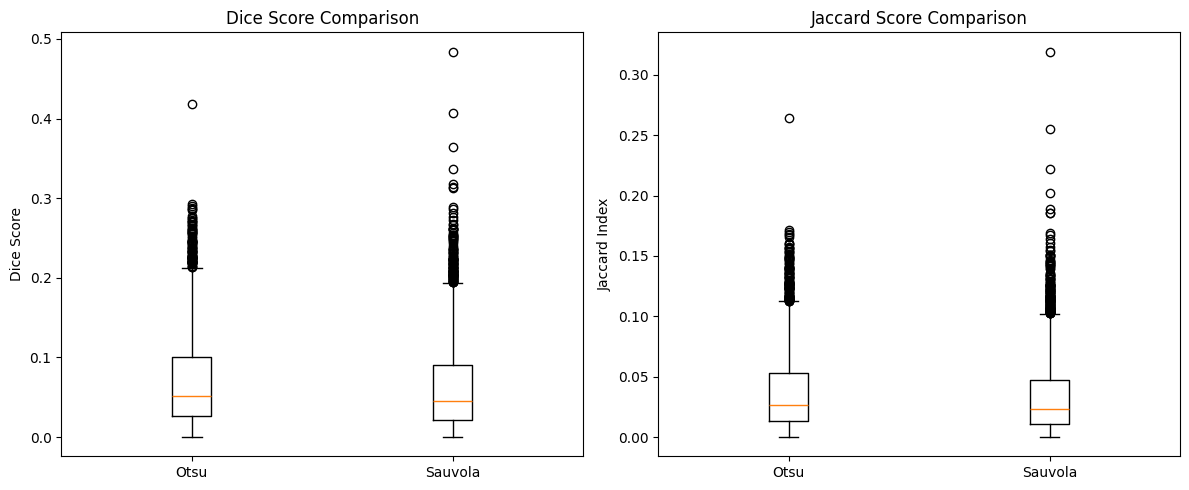

In [134]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.boxplot([dice_otsu, dice_sauvola])
plt.xticks([1, 2], ["Otsu", "Sauvola"]) 
plt.title("Dice Score Comparison")
plt.ylabel("Dice Score")

plt.subplot(1,2,2)
plt.boxplot([jaccard_otsu, jaccard_sauvola])
plt.xticks([1, 2], ["Otsu", "Sauvola"]) 
plt.title("Jaccard Score Comparison")
plt.ylabel("Jaccard Index")

plt.tight_layout()
plt.show()

From the box plots, it can be observed that both Otsu and Sauvola have generally low values of Dice and Jaccard, mostly concentrated close to zero. Compared to Sauvola, Otsu has a marginally higher median Dice score, suggesting marginally better average tumor overlap. Sauvola presents similar dispersion but slightly lower centrality. Both methods contain several outliers. However, the wide variability and low medians confirm that threshold-based methods are too inconsistent and unreliable for the accurate segmentation of brain tumors in MRI images.

# Histogram Visualization

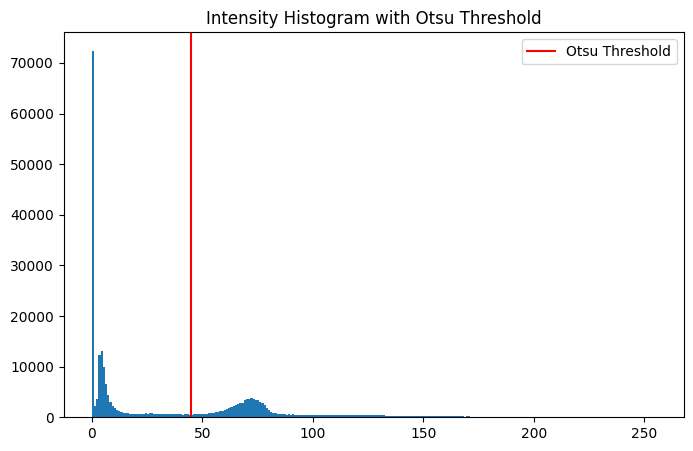

In [133]:
sample_index = 10

img = cv2.imread(os.path.join(IMAGE_DIR, image_files[sample_index]), 0)

# Otsu threshold value
blur = cv2.GaussianBlur(img, (5,5), 0)
otsu_thresh_val, _ = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.figure(figsize=(8,5))
plt.hist(img.ravel(), bins=256)
# plt.axvline(otsu_thresh, color='r', label="Otsu Threshold")
plt.axvline(otsu_thresh_val, color='r', label="Otsu Threshold")
plt.title("Intensity Histogram with Otsu Threshold")
plt.legend()
plt.show()


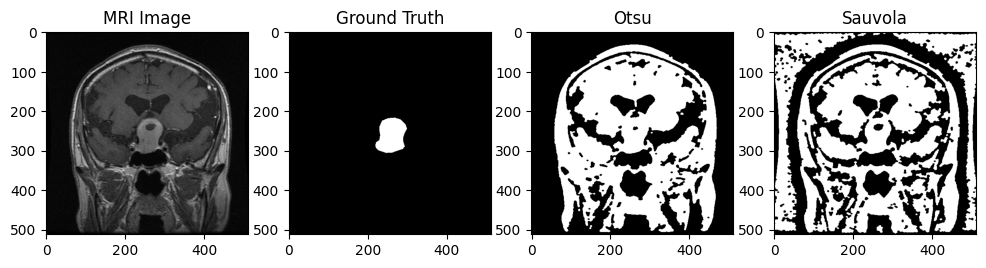

In [130]:
# Show one example

sample_index = 42

img = cv2.imread(os.path.join(IMAGE_DIR, image_files[sample_index]), 0)
mask = cv2.imread(os.path.join(MASK_DIR, mask_files[sample_index]), 0)
mask = (mask > 127).astype(np.uint8)

otsu_mask = (clean_mask(otsu_segmentation(img)) > 127).astype(np.uint8)
sauvola_mask = (clean_mask(sauvola_segmentation(img)) > 127).astype(np.uint8)

plt.figure(figsize=(12,6))

plt.subplot(1,4,1)
plt.title("MRI Image")
plt.imshow(img, cmap='gray')

plt.subplot(1,4,2)
plt.title("Ground Truth")
plt.imshow(mask, cmap='gray')

plt.subplot(1,4,3)
plt.title("Otsu")
plt.imshow(otsu_mask, cmap='gray')

plt.subplot(1,4,4)
plt.title("Sauvola")
plt.imshow(sauvola_mask, cmap='gray')

plt.show()

After applying Global Otsu and Sauvola adaptive thresholding on the Brain MRI dataset, we evaluated their performance using Dice, Jaccard, Precision, Recall, Specificity, and Accuracy.

# Average Results
**Otsu**

* Dice: 0.0703
* Jaccard: 0.0374
* Precision: 0.0375
* Recall: 0.9487
* Specificity: 0.5484
* Accuracy: 0.5549

**Sauvola**

* Dice: 0.0625
* Jaccard: 0.0332
* Precision: 0.0337
* Recall: 0.7351
* Specificity: 0.6377
* Accuracy: 0.6384

**Observations**

Otsu achieves very high recall, meaning it detects most tumor pixels. However, its precision is extremely low, indicating heavy over-segmentation.
Sauvola performs slightly better in background handling but still produces significant noise.
Dice and Jaccard remain very low for both methods.
From the visual results, Otsu segments large portions of the brain instead of isolating the tumor, showing that global thresholding is not suitable for MRI data, same with Sauvola

**Conclusion**

Both global and adaptive thresholding perform poorly for brain tumor segmentation.
MRI intensities overlap between tumor and healthy tissue, making simple intensity-based methods ineffective. This experiment highlights why advanced models like CNNs or U-Net are preferred for medical image segmentation.